# ECE1724 - Assignment 2
Prepared by Talha Alvi and Farhan Wadia

## Question 1

## Question 2

In [1]:
import pandas as pd

# Import the dataset
df = pd.read_csv('GTA Delivery Dataset\GTA Delivery Data.csv')

In [2]:
# Obtain the unique collection (source) locations and how many dropoff locations each serves
collection_locations = df.groupby(['collection_lat', 'collection_lng']).size().reset_index().rename(columns={0:'Dropoff Locations Count'})
collection_locations

collection_lat  collection_lng  Dropoff Locations Count
0       43.643481      -79.399857                        1
1       43.805779      -79.518231                      115
2       43.838713      -79.315498                       59

In [3]:
import numpy as np
from ipyleaflet import *

# Plot the locations on a map

# Define center point for map
avg_lat = np.average(df[['collection_lat', 'dropoff_lat']].values.flatten())
avg_lng = np.average(df[['collection_lng', 'dropoff_lng']].values.flatten())
center = (avg_lat, avg_lng)

m = Map(center=center, zoom=8.5)

# Define dropoff marker colours corresponding to each collection location
dropoff_colours =['green', 'orange', 'purple']

for collection_location_index, collection_location_row in collection_locations.iterrows():
    # Plot collection locations with blue marker and icon colour corresponding to dropoff locations
    filtered = df[df["collection_lat"] == collection_location_row['collection_lat']]
    m.add_layer(Marker(location=(collection_location_row['collection_lat'], collection_location_row['collection_lng']), 
                       icon=AwesomeIcon(name='car', marker_color='blue', icon_color=dropoff_colours[collection_location_index]), 
                       draggable=False))
    
    #Plot dropoff locations in colours corresponding to source (i.e. collection location)
    for index, row in filtered.iterrows():
         m.add_layer(Marker(location=(row['dropoff_lat'], row['dropoff_lng']), 
                            icon=AwesomeIcon(name='map-marker', marker_color=dropoff_colours[collection_location_index]),
                            draggable=False))
    
m

Map(center=[43.760270587628575, -79.46285720082858], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Question 3

### Preparation

In [4]:
import folium

# Arbitrarily pick the first 2 destinations of the 3rd source
source = (collection_locations.iloc[2, 0], collection_locations.iloc[2, 1])
dest1 = (df[df["collection_lat"] == source[0]].iloc[0, 3], df[df["collection_lat"] == source[0]].iloc[0, 4])
dest2 = (df[df["collection_lat"] == source[0]].iloc[1, 3], df[df["collection_lat"] == source[0]].iloc[1, 4])

# Plot the locations
m = folium.Map(location=source, zoom_start=11)
folium.Marker(location=source,icon=folium.Icon(color='purple',icon='car', prefix='fa')).add_to(m)
folium.Marker(location=dest1,icon=folium.Icon(color='purple',icon='map-marker', prefix='fa')).add_to(m)
folium.Marker(location=dest2,icon=folium.Icon(color='purple',icon='map-marker', prefix='fa')).add_to(m)

m

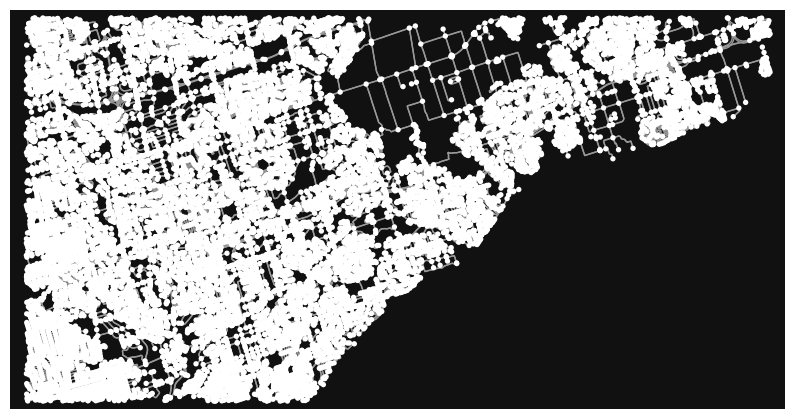

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot: >)

In [5]:
import osmnx
import math

# Create the road network graph

south = min(source[0], dest1[0], dest2[0]) # min lat
north = max(source[0], dest1[0], dest2[0]) # max lat
west = min(source[1], dest1[1], dest2[1]) # min lng
east = max(source[1], dest1[1], dest2[1]) # max lng

graph = osmnx.graph_from_bbox(north, south, east, west, network_type='drive', simplify=True, clean_periphery=True)

# Plot the graph
osmnx.plot_graph(graph,figsize=(10,10))

In [6]:
# Don't run this as it slows everything down!
#osmnx.folium.plot_graph_folium(graph, graph_map=m)

In [9]:
import geopandas

# Find closest graph nodes to source and destinations
X = [source[1], dest1[1], dest2[1]]
Y = [source[0], dest1[0], dest2[0]]
closest_nodes = osmnx.distance.nearest_nodes(graph,X,Y)

# Get the rows from the Node GeoDataFrame
nodes, edges = osmnx.graph_to_gdfs(graph)
closest_rows = nodes.loc[closest_nodes]

# Put the nodes into a GeoDataFrame
od_nodes = geopandas.GeoDataFrame(closest_rows, geometry='geometry', crs=nodes.crs)
od_nodes

y          x  ref         highway  street_count  \
osmid                                                                 
319291881   43.836227 -79.315404  NaN  turning_circle             1   
1560932706  43.700227 -79.425240  NaN             NaN             3   
392180442   43.875354 -78.952204  NaN             NaN             3   

                              geometry  
osmid                                   
319291881   POINT (-79.31540 43.83623)  
1560932706  POINT (-79.42524 43.70023)  
392180442   POINT (-78.95220 43.87535)

In [15]:
import networkx as nx

# Check shortest paths found by networkx

route1 = nx.shortest_path(G=graph,source=closest_nodes[0],target=closest_nodes[1], weight='length')
route2 = nx.shortest_path(G=graph,source=closest_nodes[0],target=closest_nodes[2], weight='length')
print("Route 1: ", route1)
print("Route 2: ", route2)

Route 1:  [319291881, 319291589, 296268408, 428077115, 428078251, 428078262, 428078252, 35228597, 35226545, 35227376, 48956065, 7638888403, 7638888409, 2895479446, 2895483166, 372414913, 1697003969, 1697003964, 1697003953, 1697003927, 1696972305, 1696972300, 1696972294, 8180730715, 25777968, 29660206, 29660184, 430996638, 1591203416, 430996652, 414429842, 430996632, 430996657, 266907559, 305256789, 2249357592, 2249357585, 266907521, 430951111, 446587207, 439316901, 446587210, 446587218, 90779304, 266904719, 90778509, 427548448, 90778464, 90778461, 90778452, 90778438, 90778419, 90798070, 90798069, 90798057, 90798050, 90798010, 90798029, 90798037, 3594445183, 3594445173, 3594445167, 1559896672, 1559896670, 1559896669, 1559886355, 1559886354, 1559886353, 1559896665, 1559896663, 1559896662, 196275859, 196275957, 196276002, 1559896595, 196276103, 196276176, 147051112, 1276594511, 254480591, 5688293902, 4242981035, 147050952, 56922345, 390371917, 63726710, 63726654, 36532056, 36531165, 36531

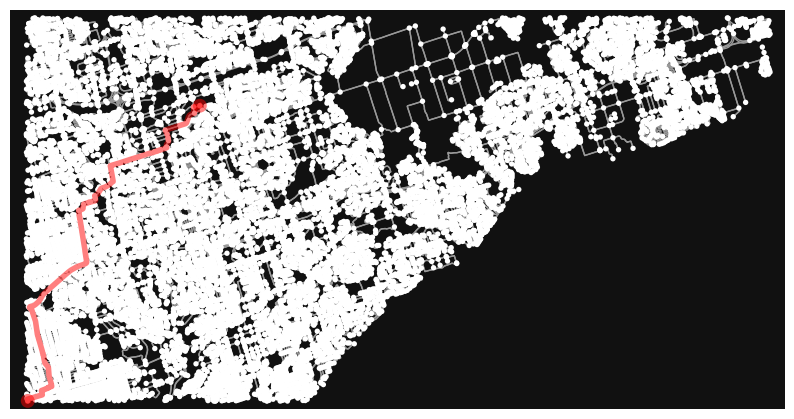

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot: >)

In [16]:
osmnx.plot_graph_route(graph,route1,figsize=(10,10))

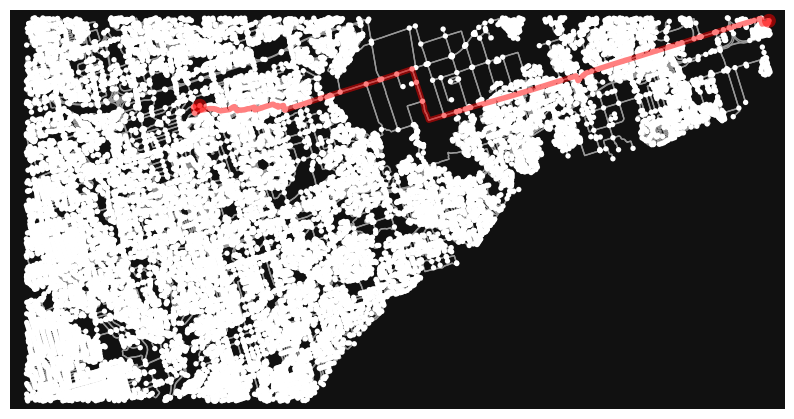

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot: >)

In [17]:
osmnx.plot_graph_route(graph,route2,figsize=(10,10))

### Djikstra

### Simulated Annealing